# Systematic Uncertainties

It is very important to know how to treat systematic uncertainties in the analysis.

You can find instructions on how this is done in the [Practical Statistics for the LHC](https://arxiv.org/pdf/1503.07622.pdf) from page 17 on. However, it is a bit complicated and goes too much into detail.

A guide that I can really recomment is the note [Probability Density Functions for Positive Nuisance Parameters](http://www.physics.ucla.edu/~cousins/stats/cousins_lognormal_prior.pd) by Bob Cousins (one of the statistics gurus from the pre-LHC era). In this tutorial, we will implement the procedure that he recommends and that is still used widely in CMS.

Again we start with imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Since I don't want to repeat the big statistics functions from the previous tutorial in this notebook, I put them into a file `statistics_tools.py` from which we will import them:

In [2]:
from geeksw.stats.statistics_tools import asymptotic_discovery_fit, make_nll_func

We create the same example datacard as last time:

In [3]:
datacard = pd.DataFrame(dict(WWW=[27.90, 16.07, 0, 0, 0],
                             WWZ=[0.91, 0.91, 8.57, 0, 0],
                             WZZ=[0.18, 0.01, 0.34, 1.08, 0.01],
                             ZZZ=[0, 0, 0.07, 0.25, 0.41],
                             VH_WWW=[17.62, 8.47, 0, 0, 0],
                             VH_WWZ=[0, 0,  5.6+0.09+0.17, 0, 0],
                             VH_WZZ=[0.0, 0, 0, 0, 0],
                             VH_ZZZ=[0.0, 0, 0, 0, 0],
                             B=[447.21, 94.99, 15.76, 0.55, 0.06]),
                        index=["SSplusJets", "3leptons", "4leptons", "5leptons", "6leptons"])
datacard.index.name = "bin"

In [4]:
datacard

,WWW,WWZ,WZZ,ZZZ,VH_WWW,VH_WWZ,VH_WZZ,VH_ZZZ,B
bin,,,,,,,,,
SSplusJets,27.90,0.91,0.18,0.00,17.62,0.00,0.0,0.0,447.21
3leptons,16.07,0.91,0.01,0.00,8.47,0.00,0.0,0.0,94.99
4leptons,0.00,8.57,0.34,0.07,0.00,5.86,0.0,0.0,15.76
5leptons,0.00,0.00,1.08,0.25,0.00,0.00,0.0,0.0,0.55
6leptons,0.00,0.00,0.01,0.41,0.00,0.00,0.0,0.0,0.06


We need to import the `scipy.stats` package to get easy access to some standard probability distributions.

In [5]:
import scipy.stats

Remember that the likelihood fits we performed so far are done in a purely frequentist approach by answering the question "what is the likelihood to obtain the observations given a model?".

For the treatment of nuisance parameters, it is common to take a Bayesian approach by using the posterior probability distributions of nuisance parameters after we estimate it somehow with the information we have on them already.

For example, we might have measured some scale factors that we applied to the weights of the Monte Carlo events. Assume that there is an uncertainty on this scale of maybe 5 %. That means we have to add a nuisance parameter to scale the Monte Carlo which we expect somehow between 0.95 and 1.05. We could encode this in a Gaussian probability distribution with mean 1.0 and width 0.05:

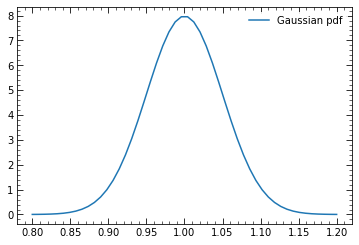

In [6]:
x = np.linspace(0.8, 1.2)
plt.plot(x, scipy.stats.norm.pdf(x, scale=0.05, loc=1.), label="Gaussian pdf")
plt.legend()
plt.show()

When we build our negative log-likelihood function, we therefore just have to add one "penalty" term corresponding to this Gaussian. Let's create a function to create this term for a given relative uncertainty estimate and nuisance parameter value: 

In [7]:
def normal_penalty(x, relative_uncertainty):
    sigma = relative_uncertainty
    return -scipy.stats.norm.logpdf(x, scale=sigma, loc=1.)

As expected, the penalty gets higher the further away we get from the expected value 1.0:

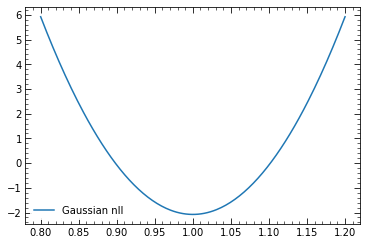

In [8]:
relative_uncertainty = 0.05
x = np.linspace(0.8, 1.2, 200)
plt.plot(x, normal_penalty(x, relative_uncertainty), label="Gaussian nll")
plt.legend()
plt.show()

There is just one problem: when we talk about scale corrections, negative scales are unphysical and the penalty should be theoretically infinite. However, a Gaussian also has support for negative values, which gets clear when we consider a large scale uncertainty of let's say 50 % (note the change in the x-axis scale):

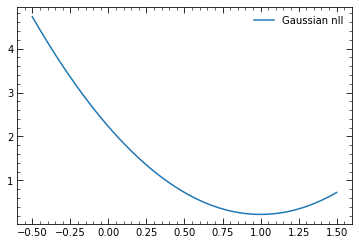

In [9]:
relative_uncertainty = 0.5
x = np.linspace(-0.5, 1.5, 200)
plt.plot(x, normal_penalty(x, relative_uncertainty), label="Gaussian nll")
plt.legend()
plt.show()

That should not be! A Guassian is therefore not the right distribution for scale uncertainties. However, most uncertainties in practice **are** scale uncertainties. That's why we need to look at different distributions.

The natural choise for scale uncertainties is the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution#Statistical_Inference), which is only defined for positive values. I will not go in details about the motivation here, because it is already perfectly summarized in Cousins note. Essentially, we expect the probability for $x$ and $1/x$ to be the same instead of for $1+x$ and $1-x$ when we talk about scales, which naturally leads to the log-normal distribution.

In Cousins note, the besti estimate for the scale is associated with the **median** of the distribution. For us, that means the median is assumend to be 1, since we assume to have already applied the scale in Monte Carlo. The median of the log-normal distribution is $\log(\mu)$, hence we set $\mu$ to zero.

Note that sometimes people associate the **mean** or the **mode** with the best estimate, which is why I implemeted this in our `lognormal_penalty` function as well. The default is the median, though.

In [10]:
def lognormal_penalty(x, relative_uncertainty, associate_best_estimate_with='median'):
    kappa = relative_uncertainty+1.
    sigma = np.log(kappa)
    if associate_best_estimate_with == 'median':
        mu = 0
    if associate_best_estimate_with == 'mean': 
        mu = -sigma**2./2
    if associate_best_estimate_with == 'mode': 
        mu = relative_uncertainty**2.
    return -scipy.stats.lognorm.logpdf(x, sigma, loc=mu)

Great, so now we have a negative log-likelihood penalty that converges towards infinity at zero from the right, just as it should behave.

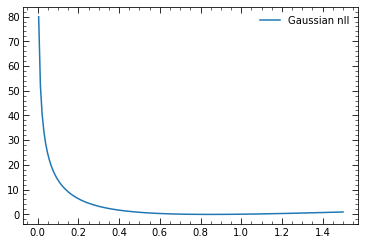

In [11]:
relative_uncertainty = 0.5
x = np.linspace(-0.2, 1.5, 200)
plt.plot(x, lognormal_penalty(x, relative_uncertainty), label="Gaussian nll")
plt.legend()
plt.show()

Finally, Cousins note mentions the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) which has to be used for uncertainties that needs to be for Monte Carlo statisitical uncertainties or uncertainties associate to extrapolations from control regions (we might go into these kind of extrapolations later).

Let's implement this penalty as described in the note as well:

In [12]:
def gamma_penalty(x, relative_uncertainty):
    a = 1./relative_uncertainty**2
    b = 1./relative_uncertainty**2 + 1
    return -scipy.stats.gamma.logpdf(a*x, b)

You can also find all of these three penalty functions in the `statistics_tools.py` file.

Finally, let's compare the three possible distribution choices for scale uncertainties.

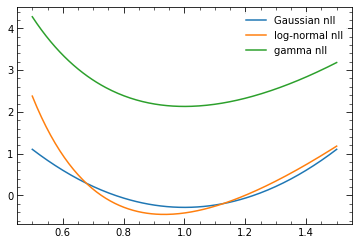

In [13]:
relative_uncertainty = 0.3
x = np.linspace(0.5, 1.5, 200)
plt.plot(x, normal_penalty(x, relative_uncertainty), label="Gaussian nll")
plt.plot(x, lognormal_penalty(x, relative_uncertainty), label="log-normal nll")
plt.plot(x, gamma_penalty(x, relative_uncertainty), label="gamma nll")
plt.legend()
plt.show()

Notive that the `gamma_penalty` is shifted compared to the others. If you read the Cousins note carefully, you might remember that there is an issue with the normalization of the gamma distribution in this application. This reflects in a constant shift in the negative log-likelihood, which is not relevant if we want to find the  minimum.

Another thing to keep in mind is that all three distributions converge towards a Gaussian for small relative uncertainties, as illustrated here with a 2 % uncertainty:

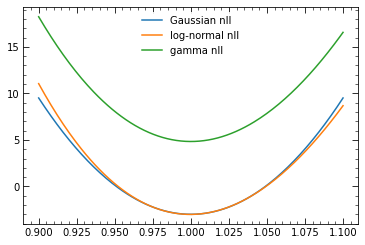

In [14]:
relative_uncertainty = 0.02
x = np.linspace(0.9, 1.1, 200)
plt.plot(x, normal_penalty(x, relative_uncertainty), label="Gaussian nll")
plt.plot(x, lognormal_penalty(x, relative_uncertainty), label="log-normal nll")
plt.plot(x, gamma_penalty(x, relative_uncertainty), label="gamma nll")
plt.legend()
plt.show()

## Using Nuisance Parameters in our Fitting Tools

Let's see how nuisance parameters can be used with our negative log-likelihood builder and asymptotic fit tool.

Here is just a reminder how to use it without nuisance parameters, with some random signal definitions:

In [15]:
signal_strengths = dict(mu_WWW="WWW", mu_WWZ="WWZ", mu_WZZ="WZZ", mu_ZZZ="ZZZ")

In [16]:
fit_result = asymptotic_discovery_fit(datacard, signal_strengths)
fit_result.df_mu

,value,error,precision,significance,p_value
mu_WWW,1.001083,0.519374,0.518812,1.994590,0.023044
mu_WWZ,0.999151,0.647161,0.647711,1.714708,0.043199
mu_WZZ,0.998764,1.329986,1.331632,0.864676,0.193608
mu_ZZZ,1.002636,1.695322,1.690865,0.998224,0.159085


In [17]:
fit_result.df_nuisance

,value,error,precision


As expected, the nuisance parameter data frame is empty.

If you want to add nuisance parameters to the fit, you have to pass the function a list of functions corresponding to the different nuisance parameters. Yes, a list of functions can be a thing in python.

As an example, let's try out some 30 % scale uncertainty $\beta$ on the overall background.

The nuisance parameter function must have a very specific interface:
* it should take two arguments: the nuisance parameter value and the datacard
* it should modify the datacard according to the nuisance parameter (in this example just scale the background category `B` by $\beta$)
* it should return two things: the modified data frame and the penalty term to add to the negative log-lilkelihood

In [18]:
def overall_background_nuisance(beta, datacard):
    datacard[["B"]] *= beta 
    return datacard, lognormal_penalty(beta, 0.3)

We now put this single nuisance parameter function in a list `nuisances` and pass this to the `asymptotic_discovery_fit` function. You will see the returned nuisances data frame is no longer empty!

In [19]:
nuisances = [overall_background_nuisance]
fit_result = asymptotic_discovery_fit(datacard, signal_strengths, nuisances)
fit_result.df_mu

,value,error,precision,significance,p_value
mu_WWW,1.091105,1.096367,1.004823,1.003734,0.157753
mu_WWZ,1.015056,0.667348,0.657449,1.662100,0.048246
mu_WZZ,1.008001,1.334084,1.323495,0.868460,0.192571
mu_ZZZ,1.001874,1.692715,1.689549,1.000510,0.158532


In [20]:
fit_result.df_nuisance

,value,error,precision
beta,0.990954,0.095315,0.096185


That worked great! As expected, adding an overall 30 % uncertainty on the background changed the expected significance quite a bit, especially for the *WWW* analysis because it has a lot of background.

## Conclusion

You know now how to encorporate systematic uncertainties in your analysis correctly. The only issue that we didn't discuss is asymmetric uncertainties, where the uncertainty in one direction is higher than in the other direction. This is done quite a lot in CMS by interpolating different distributions functions on each side, which would be a bit too much detail for this project.

You learned how to implement systematic uncertainties in our fitting tool: this is done in a very general way by defining a function for each nuisance parameter that morphs the datacard and returns a negative log-likelihood penalty.

**What you could do if you like a good challenge (might take too long for this project):** can you consider the statisitical uncertainty from Monte Carlo as a systematic uncertainty in your four lepton analsyis? We discussed how to get these uncertainties in an earlier exercice. Using them as systematics will not be easy, because you need to add one nuisance parameter per bin, as they are uncorrelated!